# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  

**`Student Name`:** Suraj Dayma

**`Roll Number`:** U20230102

**`GitHub Branch`:** suraj_U20230102  

# Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Colorblind friendly color pattele (i am color blind)
plt.style.use("tableau-colorblind10") 


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from rlcmab_sampler import sampler

# Load Datasets

In [2]:
# Load datasets
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

news_df.head()

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22


In [3]:
news_df['category'].unique()

<StringArray>
[     'U.S. NEWS',         'COMEDY',      'PARENTING',     'WORLD NEWS',
 'CULTURE & ARTS',           'TECH',         'SPORTS',  'ENTERTAINMENT',
       'POLITICS',     'WEIRD NEWS',    'ENVIRONMENT',      'EDUCATION',
          'CRIME',        'SCIENCE',       'WELLNESS',       'BUSINESS',
 'STYLE & BEAUTY',   'FOOD & DRINK',          'MEDIA',   'QUEER VOICES',
  'HOME & LIVING',          'WOMEN',   'BLACK VOICES',         'TRAVEL',
          'MONEY',       'RELIGION',  'LATINO VOICES',         'IMPACT',
       'WEDDINGS',        'COLLEGE',        'PARENTS', 'ARTS & CULTURE',
          'STYLE',          'GREEN',          'TASTE', 'HEALTHY LIVING',
  'THE WORLDPOST',      'GOOD NEWS',      'WORLDPOST',          'FIFTY',
           'ARTS',        'DIVORCE']
Length: 42, dtype: str

In [4]:
train_users.head()

,user_id,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,...,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber,label
0,U7392,NaN,23053,10,500.00,17.34,0.36661,37.29781,3,187.44,...,4.0,2.0,8,3.17.97,10,22.75,8.0,Z999,False,user_3
1,U2702,56.0,20239,11,913.33,22.22,0.61370,59.36342,5,145.15,...,4.5,63.0,5,1.57.10,8,1.75,4.0,U428,True,user_2
2,U2461,NaN,13907,9,1252.62,41.57,0.80368,76.78706,7,282.03,...,1.3,22.0,2,2.16.94,12,29.33,18.0,Z999,True,user_3
3,U7475,NaN,26615,12,500.00,30.17,0.26499,30.19441,10,195.35,...,4.2,77.0,9,9.90.20,4,21.61,22.0,X123,False,user_3
4,U6040,32.0,27958,13,500.00,65.27,0.36385,37.12153,5,439.68,...,4.6,30.0,9,1.99.38,7,7.58,52.0,S043,False,user_1


## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [5]:
for name, df in {
    "news": news_df,
    "train_users": train_users,
    "test_users": test_users
}.items():
    print(f"\n{name}")
    print(f"Total entries: {len(df)}")
    na_counts = df.isna().sum()
    na_counts = na_counts[na_counts > 0]
    if not na_counts.empty:
        print(na_counts)

print(f'\n{(news_df["category"] == "").sum()=}')
print(f'{(train_users["label"] == "").sum()=}')


news
Total entries: 209527
headline                 6
short_description    19712
authors              37418
dtype: int64

train_users
Total entries: 2000
age    698
dtype: int64

test_users
Total entries: 2000
age    679
dtype: int64

(news_df["category"] == "").sum()=np.int64(0)
(train_users["label"] == "").sum()=np.int64(0)


**Null Value Handling**
1. All the news articles do have a non null or empty category.
2. Filling in the missing age as the median value of the entire dataset.

In [6]:
train_users['age'] = train_users['age'].fillna(train_users['age'].median())
test_users['age'] = test_users['age'].fillna(test_users['age'].median())

In [7]:
# Find non-numeric columns in train_users and test_users
non_numeric_train_users = train_users.select_dtypes(include='object').columns.tolist()
non_numeric_test_users = test_users.select_dtypes(include='object').columns.tolist()

print("Non-numeric columns in train_users:", non_numeric_train_users)
print("Non-numeric columns in test_users:", non_numeric_test_users)

Non-numeric columns in train_users: ['user_id', 'browser_version', 'region_code', 'label']
Non-numeric columns in test_users: ['user_id', 'browser_version', 'region_code']


/var/folders/lx/8dqwd2x96b3gmdmvm7rg5tr00000gn/T/ipykernel_88356/4123833300.py:2: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  non_numeric_train_users = train_users.select_dtypes(include='object').columns.tolist()
/var/folders/lx/8dqwd2x96b3gmdmvm7rg5tr00000gn/T/ipykernel_88356/4123833300.py:3: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silenc

In [8]:
print(f"{train_users['browser_version'].nunique()=}")
print(f"{train_users['region_code'].nunique()=}")
print(f"{train_users['label'].nunique()=}")

train_users['browser_version'].nunique()=1973
train_users['region_code'].nunique()=1284
train_users['label'].nunique()=3


**Drop Columns and Encode**
- Droppping `user_id` as it is not needed for classification.
- There are 2000 training points with 1973 unique browser version, therefore dropping `browser_version` as well.
- Dropping `region_code` as well as 1284 unique variation.
- `subscriber` already encoding as True / False or 0 / 1

In [9]:
columns_to_drop = ['user_id', 'browser_version', 'region_code']

train_users = train_users.drop(columns=columns_to_drop, errors='ignore')
test_users = test_users.drop(columns=columns_to_drop, errors='ignore')

## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.

> The classifier code can be found in `classifiers.py`

In [26]:
import classifiers as myclsf

# Drop user_id col 
train_users = train_users.drop(columns=["user_id"], errors='ignore')

X_train, y_train, X_test, y_test, le = myclsf.preprocess(train_users)
results, models = myclsf.train_classifiers(X_train, y_train, X_test, y_test)
results

/opt/homebrew/Caskroom/miniforge/base/envs/mlpr/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 10000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=10000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'Logistic Regression': 0.73,
 'Random Forest': 0.7925,
 'SVM (RBF)': 0.46,
 'KNN': 0.5775,
 'Neural Network': 0.3625}

After trying multiple methods, **Random Forest** has the best accuracy, and will be used as the classifier for subsequest tasks.

In [27]:
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
best_model

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

---

# Contextual Bandit

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


# `NOTE: `
All the above tasks have been implemented in the files `bandit.py`, `agents.py`, and `experiments.py`. See `README.md` for more info.

In [12]:
from bandit import *
from agents import *
from experiments import *

## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


Run: 100%|██████████| 333/333 [00:09<00:00, 35.74it/s]


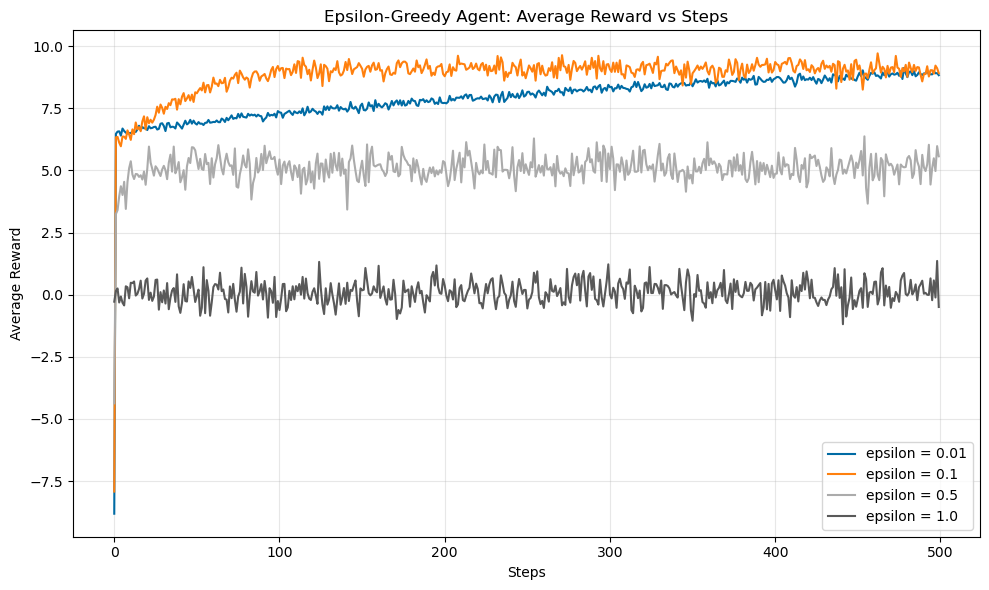

In [13]:
run_agent_comparison(
    agent_type=GreedyBanditAgent,
    metrics=[0.01, 0.1, 0.5, 1.0],
    initial_value=0,
    steps=500,
    runs=1_000
)

Run: 100%|██████████| 333/333 [00:11<00:00, 28.63it/s]


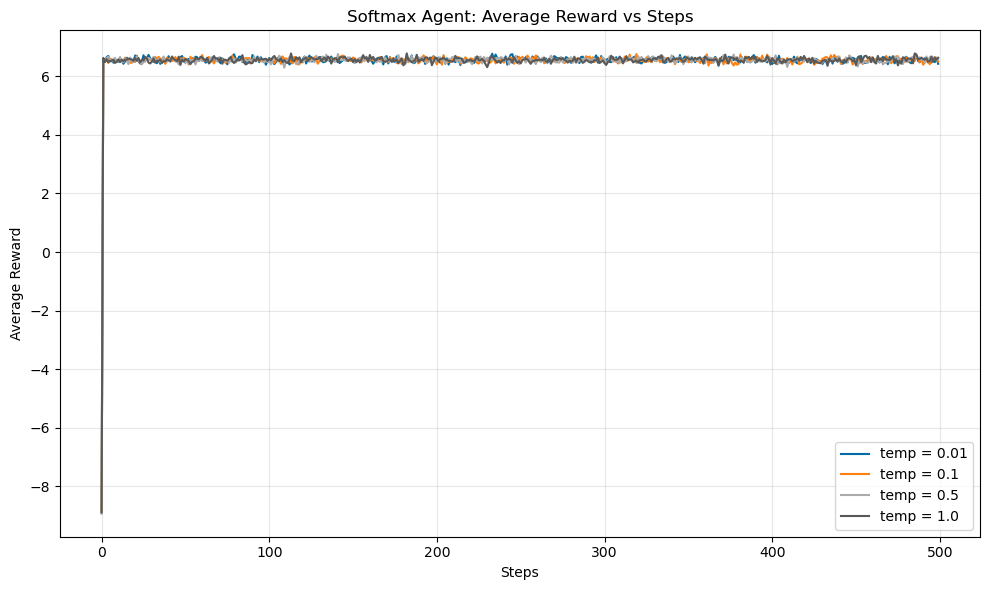

In [14]:
run_agent_comparison(
    agent_type=SoftmaxBanditAgent,
    metrics=[0.01, 0.1, 0.5, 1.0],
    initial_value=0,
    steps=500,
    runs=1_000
)

Run: 100%|██████████| 333/333 [00:11<00:00, 28.65it/s]


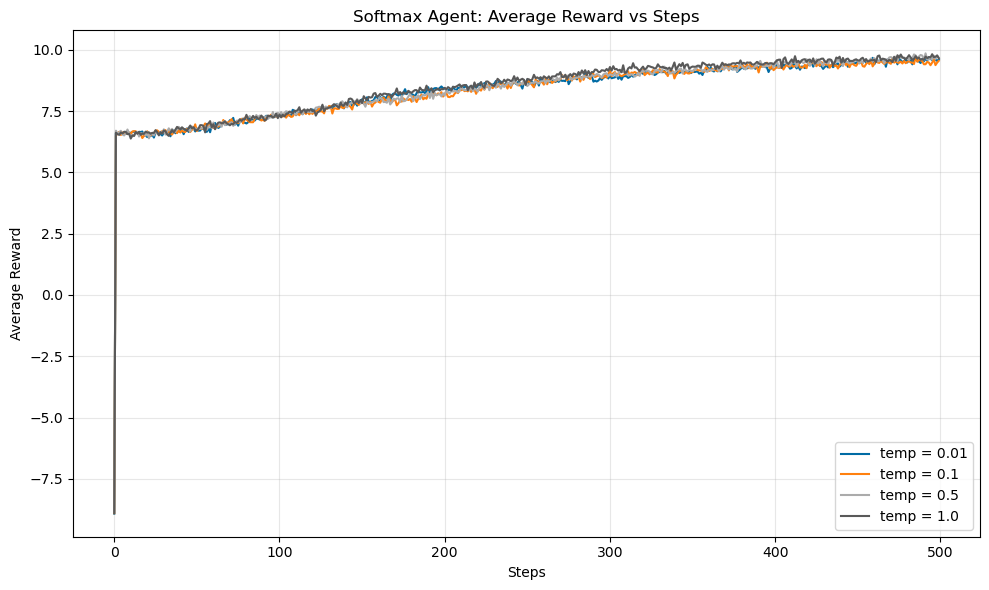

In [15]:
run_agent_comparison(
    agent_type=SoftmaxBanditAgent,
    metrics=[0.01, 0.1, 0.5, 1.0],
    initial_value=3,
    steps=500,
    runs=1_000
)

Run: 100%|██████████| 333/333 [00:05<00:00, 64.20it/s]


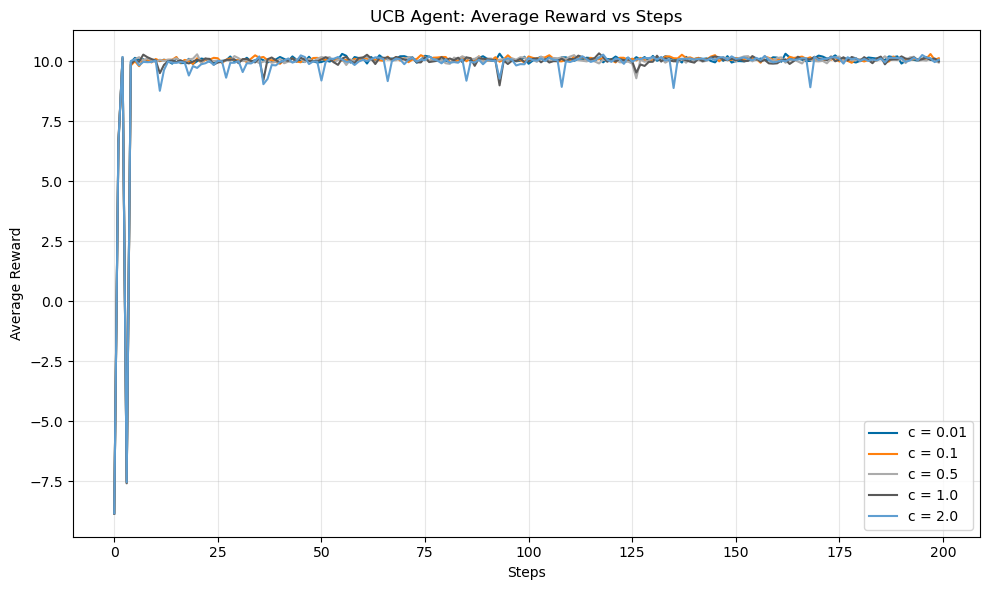

In [24]:
run_agent_comparison(
    agent_type=UCBBanditAgent,
    metrics=[0.01, 0.1, 0.5, 1.0, 2.0],
    initial_value=0,
    steps=200,
    runs=1_000
)

## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach


> See in `README.md`

# Full Pipeline Including Reccomendation for News Article

In [29]:
test_y_encoded = best_model.predict(test_users)
test_y = le.inverse_transform(test_y_encoded)
test_users["label"] = test_y
test_users.head()

,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,avg_cart_value,...,churn_risk_score,loyalty_index,screen_brightness,battery_percentage,cart_abandonment_count,background_app_count,session_inactivity_duration,network_jitter,subscriber,label
0,36.0,10000,4,500.00,2.54,0.47162,49.32668,8,229.80,73.26,...,0.514808,13.0,3.0,39.0,3,7,7.86,26.0,True,user_2
1,33.0,19607,8,1906.81,39.74,0.55219,56.42526,4,819.43,520.44,...,0.514304,30.0,4.6,84.0,5,12,2.79,42.0,True,user_1
2,51.0,21049,11,500.00,46.07,0.69961,58.88307,5,113.35,49.14,...,0.364154,21.0,2.1,88.0,7,11,27.50,11.0,False,user_1
3,58.0,25752,13,500.00,60.86,0.86843,86.15690,8,237.13,31.75,...,0.065866,37.0,1.9,34.0,7,15,22.21,34.0,False,user_1
4,32.0,25302,12,2693.22,39.77,0.81805,84.82418,5,1491.56,572.96,...,0.117989,45.0,3.0,6.0,6,8,11.44,0.0,False,user_1


In [ ]:
bandit = MultiArmedBandit(k = 12);
user1_agent = UCBBanditAgent(4, None, 0, 0.1)
user2_agent = UCBBanditAgent(4, None, 0, 0.1)
user3_agent = UCBBanditAgent(4, None, 0, 0.1)
agents = [user1_agent, user2_agent, user3_agent]

steps = 10_000
for t in range(steps):
    for i in range(len(agents)):
        # Select an action
        action_t = agents[i].select_action()
        # Get reward
        action_offset = i * 4;
        reward_t = bandit.pull(action_t + action_offset)
        # Update Q function using the reward
        agents[i].update(action_t, reward_t)

# Sample one point from test_users
sampled_user = test_users.sample(n=1, random_state=102).iloc[0]
print(f"{sampled_user["label"]=}")
user_label = sampled_user["label"]

agent_idx = int(user_label[-1]) - 1

# Select action from appropriate agent
action = agents[agent_idx].select_action()
if action == 0:
    news_cat = "ENTERTAINMENT"
elif action == 1:
    news_cat = "EDUCATION"
elif action == 2:
    news_cat = "TECH"
elif action == 3:
    news_cat = "CRIME"

print(f"Recommended news category for the user: {news_cat}")

# Sample an article from the recommended category
recommended_articles = news_df[news_df["category"] == news_cat]
sampled_article = recommended_articles.sample(n=1, random_state=102).iloc[0]
sampled_article

sampled_user["label"]='user_2'
Recommended news category for the user: ENTERTAINMENT


link                 https://www.huffingtonpost.com/entry/hotel-tra...
headline             'Hotel Transylvania' Sets Box Office Records F...
category                                                 ENTERTAINMENT
short_description    Sony's animated Halloween-themed movie, featur...
authors                                                            NaN
date                                                        2012-09-30
Name: 186723, dtype: str